# Notebook 5: Online Inference with IBIS

This notebook demonstrates online/streaming inference using IBIS (Iterated Batch Importance Sampling).

**Learning objectives:**
- Understand online vs. batch inference
- Learn how IBIS processes streaming data
- Compare IBIS with batch methods
- Visualize posterior evolution over time

## Setup

In [ ]:
# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

# Fix import path
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from infodynamics_jax.core import Phi, SupervisedData
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.kernels.rbf import rbf as rbf_kernel
from infodynamics_jax.gp.likelihoods import get as get_likelihood
from infodynamics_jax.energy import InertialEnergy, InertialCFG
from infodynamics_jax.inference.particle import AnnealedSMC, AnnealedSMCCFG

print(f"JAX version: {jax.__version__}")

Metal device set to: Apple M4
JAX version: 0.8.2


W0000 00:00:1768292465.183812 15455258 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1768292465.202474 15455258 service.cc:145] XLA service 0x30ad53b90 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768292465.202485 15455258 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1768292465.203551 15455258 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1768292465.203561 15455258 mps_client.cc:384] XLA backend will use up to 11452776448 bytes on device 0 for SimpleAllocator.


## 1. Batch vs. Online Inference

### Batch Inference
- All data available at once: $\{(x_i, y_i)\}_{i=1}^N$
- Compute $p(\phi | y_{1:N})$ in one go
- Examples: MAP-II, Annealed SMC on full dataset

### Online/Streaming Inference
- Data arrives sequentially: $y_1, y_2, y_3, ...$
- Update posterior incrementally:
  - $t=1$: $p(\phi | y_1)$
  - $t=2$: $p(\phi | y_1, y_2)$
  - $t=3$: $p(\phi | y_1, y_2, y_3)$
  - ...
- Applications: Real-time systems, large datasets, concept drift detection

### IBIS (Iterated Batch Importance Sampling)

IBIS is a particle filter for sequential Bayesian inference:

1. **Initialize**: Sample particles from prior $p(\phi)$
2. **For each new batch** $y_t$:
   - **Reweight**: Update weights using likelihood $p(y_t | \phi)$
   - **Resample**: If ESS too low
   - **Rejuvenate**: MCMC moves to maintain diversity
3. **Result**: Particles approximate $p(\phi | y_{1:t})$

### IBIS vs. Annealed SMC

| Aspect | IBIS | Annealed SMC |
|--------|------|-------------|
| **Data** | Sequential batches | Full dataset |
| **Temperature** | Always $\beta=1$ | $\beta: 0 \to 1$ |
| **Use Case** | Streaming data | Batch inference |
| **Updates** | Add new data | Anneal to posterior |

## 2. Generate Streaming Data

We'll simulate a scenario where data arrives in batches.

In [2]:
key = jax.random.key(999)

# Total data
N_total = 100
X_all = jnp.linspace(-5, 5, N_total)[:, None]

# True function
def true_function(x):
    return 1.5 * jnp.sin(1.5 * x[:, 0]) + 0.5 * jnp.cos(3 * x[:, 0])

f_all = true_function(X_all)

# Add noise
key, subkey = jax.random.split(key)
noise_std = 0.3
Y_all = f_all + noise_std * jax.random.normal(subkey, (N_total,))

# Create SupervisedData
data = SupervisedData(X_all, Y_all)

print(f"Total data points: {N_total}")
print(f"True noise std: {noise_std}")
print(f"Data object: {data}")

Total data points: 100
True noise std: 0.3
Data object: SupervisedData(X=Array([[-5.        ],
       [-4.8989897 ],
       [-4.7979794 ],
       [-4.69697   ],
       [-4.5959597 ],
       [-4.4949493 ],
       [-4.393939  ],
       [-4.292929  ],
       [-4.1919193 ],
       [-4.090909  ],
       [-3.989899  ],
       [-3.888889  ],
       [-3.787879  ],
       [-3.6868687 ],
       [-3.5858586 ],
       [-3.4848487 ],
       [-3.3838387 ],
       [-3.2828283 ],
       [-3.181818  ],
       [-3.080808  ],
       [-2.979798  ],
       [-2.8787878 ],
       [-2.7777777 ],
       [-2.6767678 ],
       [-2.5757575 ],
       [-2.4747477 ],
       [-2.3737373 ],
       [-2.2727275 ],
       [-2.1717172 ],
       [-2.0707073 ],
       [-1.969697  ],
       [-1.8686868 ],
       [-1.7676771 ],
       [-1.6666664 ],
       [-1.5656567 ],
       [-1.4646465 ],
       [-1.3636363 ],
       [-1.2626265 ],
       [-1.1616161 ],
       [-1.0606061 ],
       [-0.9595961 ],
       [-0.8585859 ],
   

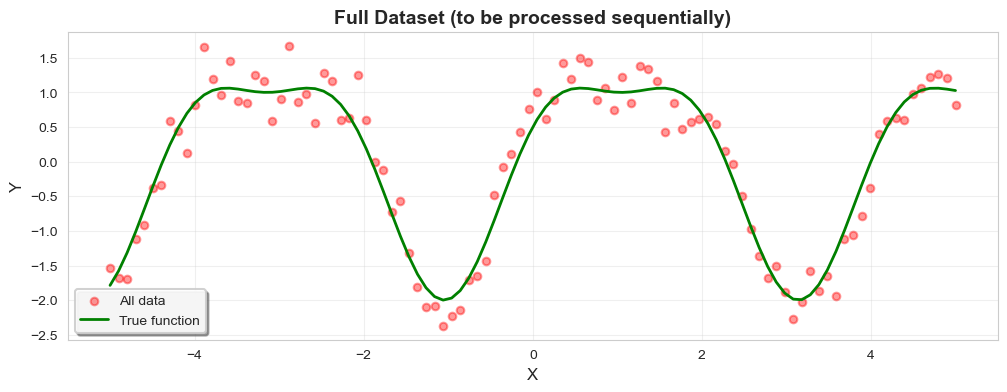

In [3]:
# Visualize full dataset
plt.figure(figsize=(12, 4))
plt.scatter(X_all[:, 0], Y_all, c='red', s=30, alpha=0.4, label='All data')
plt.plot(X_all[:, 0], f_all, 'g-', linewidth=2, label='True function')
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Full Dataset (to be processed sequentially)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Implement IBIS Loop

We'll process data in batches of 10 points each.

In [4]:
# Initialize Phi
kernel_params = KernelParams(lengthscale=jnp.array(1.0), variance=jnp.array(1.0))
M = 12
Z = jnp.linspace(X_all.min(), X_all.max(), M)[:, None]

phi_init = Phi(
    kernel_params=kernel_params,
    Z=Z,
    likelihood_params={"noise_var": jnp.array(0.1)},
    jitter=1e-5,
)

# Create energy
gaussian_likelihood = get_likelihood("gaussian")
inertial_cfg = InertialCFG(estimator="gh", gh_n=20, inner_steps=0)
inertial_energy = InertialEnergy(
    kernel_fn=rbf_kernel,
    likelihood=gaussian_likelihood,
    cfg=inertial_cfg,
)

print(f"Model initialized with {M} inducing points")

Model initialized with 12 inducing points


In [5]:
def init_particles_fn(key, n_particles: int):
    """Initialize particles from prior."""
    keys = jax.random.split(key, n_particles)
    
    def init_one(key_i):
        key_l, key_v, key_z, key_n = jax.random.split(key_i, 4)
        
        lengthscale = jnp.exp(jax.random.normal(key_l, ()) * 0.5)
        variance = jnp.exp(jax.random.normal(key_v, ()) * 0.5)
        Z_noisy = phi_init.Z + jax.random.normal(key_z, phi_init.Z.shape) * 0.2
        noise_var = jnp.exp(jnp.log(0.1) + jax.random.normal(key_n, ()) * 0.5)
        
        lengthscale = jnp.maximum(lengthscale, 0.1)
        variance = jnp.maximum(variance, 0.1)
        noise_var = jnp.maximum(noise_var, 0.01)
        
        return Phi(
            kernel_params=KernelParams(lengthscale=lengthscale, variance=variance),
            Z=Z_noisy,
            likelihood_params={"noise_var": noise_var},
            jitter=phi_init.jitter,
        )
    
    return jax.vmap(init_one)(keys)

print("Particle initialization function created")

Particle initialization function created


In [6]:
# IBIS configuration
batch_size = 10
n_batches = N_total // batch_size

smc_cfg = AnnealedSMCCFG(
    n_particles=50,
    n_steps=5,              # Fewer steps for IBIS (already at β=1)
    ess_threshold=0.5,
    rejuvenation="hmc",
    rejuvenation_steps=1,
    jit=True,
)

print(f"IBIS Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Number of batches: {n_batches}")
print(f"  Particles: {smc_cfg.n_particles}")

IBIS Configuration:
  Batch size: 10
  Number of batches: 10
  Particles: 50


In [ ]:
# Run IBIS
print("Running IBIS...\n")

# Storage for results
particles_history = []
weights_history = []
lengthscale_history = []
variance_history = []
noise_var_history = []
ess_history = []

# Initialize particles once
key, subkey = jax.random.split(key)
particles = init_particles_fn(subkey, smc_cfg.n_particles)
logw = jnp.zeros(smc_cfg.n_particles)

method = AnnealedSMC(cfg=smc_cfg)

for t in range(1, n_batches + 1):
    # Get data up to time t
    n_data = t * batch_size
    data_t = data.prefix(n_data)
    
    print(f"Batch {t}/{n_batches}: Processing {n_data} data points...")
    
    # For IBIS, we run SMC on the cumulative data
    # but starting from previous particles
    def init_from_previous(key_init, n_p):
        return particles
    
    key, subkey = jax.random.split(key)
    result = method.run(
        energy=inertial_energy,
        init_particles_fn=init_from_previous,
        key=subkey,
        energy_args=(data_t.X, data_t.Y),
    )
    
    particles = result.particles
    logw = result.logw
    
    # Store results
    particles_history.append(particles)
    weights_history.append(np.exp(logw - logw.max()))
    
    # Extract statistics
    weights = np.exp(logw - logw.max())
    weights = weights / weights.sum()
    
    lengthscales = np.array(particles.kernel_params.lengthscale)
    variances = np.array(particles.kernel_params.variance)
    noise_vars = np.array(particles.likelihood_params["noise_var"])
    
    lengthscale_mean = float(np.sum(weights * lengthscales))
    variance_mean = float(np.sum(weights * variances))
    noise_var_mean = float(np.sum(weights * noise_vars))
    
    lengthscale_history.append(lengthscale_mean)
    variance_history.append(variance_mean)
    noise_var_history.append(noise_var_mean)
    ess_history.append(float(result.ess_trace[-1]))
    
    print(f"  ESS: {result.ess_trace[-1]:.1f}, Lengthscale: {lengthscale_mean:.3f}, "
          f"Variance: {variance_mean:.3f}, Noise var: {noise_var_mean:.3f}\n")

print("IBIS complete!")

Running IBIS...

Batch 1/10: Processing 10 data points...
  ESS: 23.0, Lengthscale: 0.692, Variance: 1.005, Noise var: 0.072

Batch 2/10: Processing 20 data points...
  ESS: 36.2, Lengthscale: 1.083, Variance: 1.147, Noise var: 0.016

Batch 3/10: Processing 30 data points...
  ESS: 47.1, Lengthscale: 1.086, Variance: 1.149, Noise var: 0.011

Batch 4/10: Processing 40 data points...
  ESS: 37.5, Lengthscale: 1.107, Variance: 1.170, Noise var: 0.011

Batch 5/10: Processing 50 data points...
  ESS: 39.0, Lengthscale: 1.118, Variance: 1.183, Noise var: 0.011

Batch 6/10: Processing 60 data points...


## 4. Visualize Posterior Evolution

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

batch_indices = np.arange(1, n_batches + 1)
data_counts = batch_indices * batch_size

# Lengthscale evolution
ax = axes[0, 0]
ax.plot(data_counts, lengthscale_history, 'b-o', linewidth=2, markersize=6)
ax.set_xlabel('Number of Data Points', fontsize=12)
ax.set_ylabel('Lengthscale (Posterior Mean)', fontsize=12)
ax.set_title('Lengthscale Evolution', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Variance evolution
ax = axes[0, 1]
ax.plot(data_counts, variance_history, 'r-o', linewidth=2, markersize=6)
ax.set_xlabel('Number of Data Points', fontsize=12)
ax.set_ylabel('Variance (Posterior Mean)', fontsize=12)
ax.set_title('Variance Evolution', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Noise variance evolution
ax = axes[1, 0]
ax.plot(data_counts, noise_var_history, 'g-o', linewidth=2, markersize=6, label='IBIS estimate')
ax.axhline(y=noise_std**2, color='black', linestyle='--', linewidth=2, label=f'True ({noise_std**2:.3f})')
ax.set_xlabel('Number of Data Points', fontsize=12)
ax.set_ylabel('Noise Variance (Posterior Mean)', fontsize=12)
ax.set_title('Noise Variance Evolution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# ESS evolution
ax = axes[1, 1]
ax.plot(data_counts, ess_history, 'm-o', linewidth=2, markersize=6)
ax.axhline(y=smc_cfg.ess_threshold * smc_cfg.n_particles, 
          color='red', linestyle='--', linewidth=2, label=f'Resample threshold')
ax.set_xlabel('Number of Data Points', fontsize=12)
ax.set_ylabel('ESS', fontsize=12)
ax.set_title('Effective Sample Size Evolution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Compare Early vs. Late Posteriors

In [ ]:
# Compare posterior at t=2 (20 points) vs t=10 (100 points)
early_idx = 1  # After 20 points
late_idx = -1  # After 100 points

particles_early = particles_history[early_idx]
weights_early = weights_history[early_idx]
weights_early = weights_early / weights_early.sum()

particles_late = particles_history[late_idx]
weights_late = weights_history[late_idx]
weights_late = weights_late / weights_late.sum()

lengthscales_early = np.array(particles_early.kernel_params.lengthscale)
lengthscales_late = np.array(particles_late.kernel_params.lengthscale)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Early posterior
ax = axes[0]
ax.hist(lengthscales_early, bins=20, weights=weights_early, alpha=0.7, edgecolor='black', color='blue')
ax.set_xlabel('Lengthscale', fontsize=12)
ax.set_ylabel('Posterior Density', fontsize=12)
ax.set_title(f'After {(early_idx + 1) * batch_size} Data Points', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Late posterior
ax = axes[1]
ax.hist(lengthscales_late, bins=20, weights=weights_late, alpha=0.7, edgecolor='black', color='green')
ax.set_xlabel('Lengthscale', fontsize=12)
ax.set_ylabel('Posterior Density', fontsize=12)
ax.set_title(f'After {(late_idx + 1 if late_idx >= 0 else n_batches) * batch_size} Data Points', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observation: Posterior becomes more concentrated as more data is observed!")

## Summary

In this notebook, we demonstrated online inference with IBIS:

### Key Concepts

1. **Sequential Data**: IBIS processes data in batches, updating posterior incrementally
2. **Posterior Evolution**: Hyperparameters converge as more data arrives
3. **Uncertainty Reduction**: Posterior concentration increases with data
4. **ESS Monitoring**: Tracks particle degeneracy, triggers resampling

### IBIS Characteristics

**Advantages:**
- Handles streaming/online data naturally
- Memory-efficient (doesn't store all data)
- Can detect concept drift
- Real-time updates

**Challenges:**
- Particle degeneracy (weight collapse)
- Requires rejuvenation (MCMC moves)
- More complex than batch methods

### When to Use IBIS

**Use IBIS when:**
- Data arrives sequentially (streaming)
- Dataset too large to process in batch
- Need real-time updates
- Monitoring for distribution changes

**Use Batch Methods when:**
- All data available upfront
- Dataset fits in memory
- Offline analysis
- Simpler implementation preferred

### Implementation Tips

1. **Batch Size**: Balance between update frequency and computational cost
2. **Particle Count**: Start with 50-100 particles
3. **Rejuvenation**: Essential to maintain particle diversity
4. **ESS Threshold**: 0.5 is standard, adjust based on degeneracy rate

### Extensions

- **Adaptive batching**: Vary batch size based on ESS
- **Concept drift**: Detect when data distribution changes
- **Forgetting**: Discount old data for non-stationary processes
- **Active learning**: Choose which data to query next